| Logane TANN | Antoine Banha | LSI 1 |
| -- | -- | -- |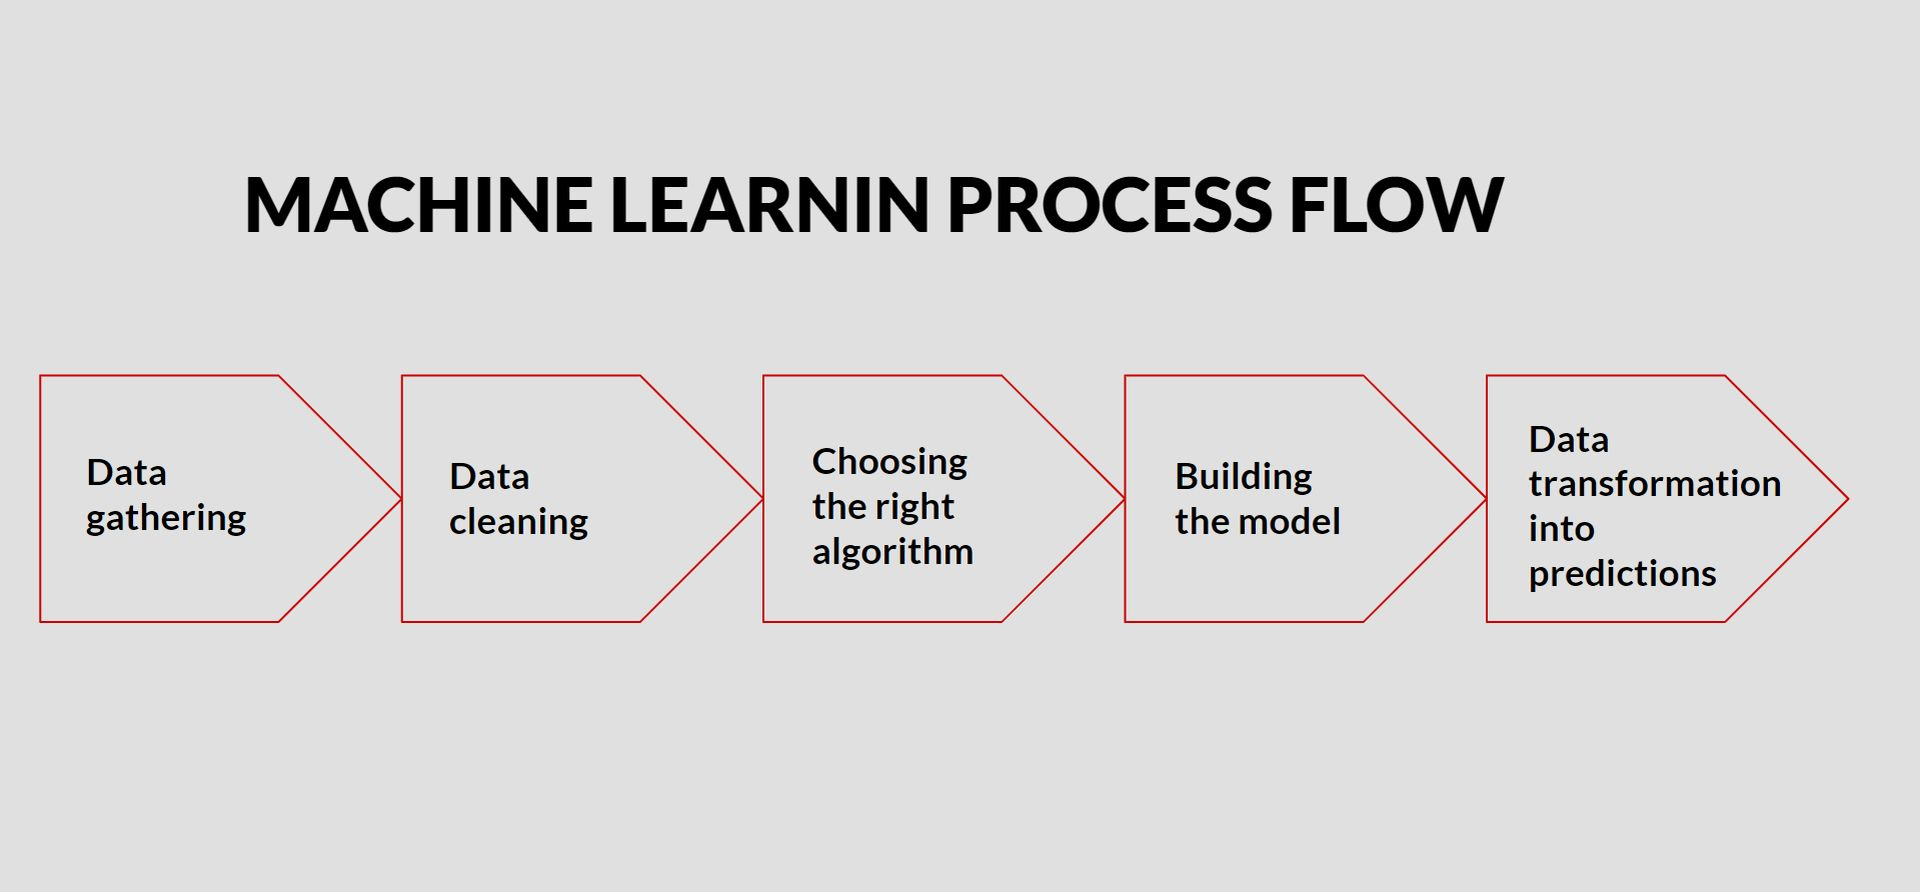

# 0. Préambule

### Contexte de la détection de texte généré par l'IA.

Pour détecter si un texte est généré par IA, on va plutôt essayer de créer un modèle capable de déterminer si un texte est similaire à du contenu généré par IA. Un peu comme si on essaie de déterminer si un texte est écrit dans le style d'un certain auteur.


### Objectifs de l'utilisation de la classification et de la réduction de la dimensionnalité

Classification : Algorithme qui nous permettra d'avoir en entrée le texte, et en sortie la classe associée (Humain ou IA ?)

Réduction de dimensionnalité : Technique mathématique pour résoudre un problème assez récurrent en machine learning, à savoir traiter des données avec un grand nombre de dimensions. Le classificateurs que nous utiliserons (DistilBert) n'a pas besoin de réduction de dimensionalité, il peut récupérer la donnée directement.

## Installation des dépendances


In [ ]:
!pip install -q keras_nlp==0.6.3 keras-core==0.1.7 scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.0 MB/s eta 0:00:00


In [ ]:
# @title Lancer les imports et le google drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["KERAS_BACKEND"] = "jax"
import keras_nlp
import keras_core as keras
import keras_core.backend as K
import torch
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn as skl
from IPython.display import display, Markdown
import ipywidgets as widgets
cmap = mpl.cm.get_cmap('coolwarm')


Mounted at /content/drive
Using JAX backend.


<ipython-input-2-075b432e168d>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [ ]:
# Dossier google drive
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/FakeText'

# XX. Démonstration de notre modèle

Vous pouvez tester le résultat du modèle sans attendre de compiler celui-ci par vous-même.

In [ ]:
# charger les données du modèle que nous avions entrainé.
compiled_model_save_path = BASE_PATH + "/../backup/faketext.keras";
compiled_model = keras.models.load_model(compiled_model_save_path)

/usr/local/lib/python3.10/dist-packages/keras_core/src/saving/saving_lib.py:347: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# @title Entrez le texte à vérifier
user_input = """
Cars have become an integral part of modern society, transforming the way we live, work, and travel. Here is a comprehensive essay on cars, exploring their history, evolution, benefits, and impact on society.

I. Introduction

* Definition of cars and their importance in modern society
* Brief history of cars and their evolution over time

II. History of Cars

* Early inventions and innovations in transportation (e.g., bicycles, trains)
* Development of the first cars in the late 19th century (e.g., Karl Benz, Henry Ford)
* Major milestones in car history (e.g., introduction of electric starters, automatic transmissions, safety features)

III. Benefits of Cars

* Convenience and flexibility in transportation
* Time-saving and efficiency in daily commutes
* Increased mobility and access to various activities and destinations
* Economic benefits (e.g., job creation, transportation infrastructure development)

IV. Impact of Cars on Society

* Environmental impact (e.g., air pollution, greenhouse gas emissions)
* Traffic congestion and road safety concerns
* Social and cultural impact (e.g., the rise of suburbanization, changes in family dynamics)
* Economic impact (e.g., job loss in traditional industries, economic inequality)

V. Future of Cars

* Advancements in electric and autonomous vehicle technology
* Shift towards sustainable and environmentally-friendly transportation options
* Impact of ride-sharing and car-sharing services on personal vehicle ownership
* Potential changes in urban planning and design to accommodate new mobility options

VI. Conclusion

* Cars have had a profound impact on modern society, transforming the way we live and travel.
* However, their environmental and social impacts have become increasingly concerning, highlighting the need for sustainable and innovative transportation solutions.
* As technology continues to advance, the future of cars will likely involve a combination of electric, autonomous, and shared vehicles, which will shape the way we move around cities and communities.

Sources:

* "A Brief History of Cars" by The History Channel
* "The Impact of Cars on Society" by The Conversation
* "The Future of Cars" by Forbes
* "The Environmental Impact of Cars" by The Union of Concerned Scientists

Note: This essay is a general overview of the topic and can be tailored to meet specific requirements or perspectives.
"""
textarea = widgets.Textarea(
    value=user_input,
    description='À vérifier:',
    disabled=False
)
display(textarea)

Textarea(value='\nCars have become an integral part of modern society, transforming the way we live, work, and…

In [ ]:
# @title Cliquez sur le bouton play
user_model_preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=512,
)
user_model_input = user_model_preprocessor([textarea.value])
user_result = compiled_model.call(user_model_input)

display(user_result[0])

from IPython.display import display, Markdown, Latex

if user_result[0, 1] > 0:
  display(Markdown('# 🤖 Votre texte est généré par IA'))
else:
  display(Markdown('# 😀 Votre texte est écrit par un humain'))

Array([-3.4850297,  3.3206365], dtype=float32)

# 🤖 Votre texte est généré par IA

# 1. Données et prétraitement

Nous allons construire un dataset de dissertations générées par l'humain et générées par l'IA en part égale.

Pour simplifier, nous allons renommer la colonne "generated" (1 = généré par IA) en "is_ai". Et supprimer les colonnes qui ne semblent pas pertinentes.

In [ ]:
data1 = pd.read_csv(BASE_PATH + '/train_essays.csv')
data1.rename(columns={ "generated": "is_ai" }, inplace=True)
data1.drop(columns=["prompt_id"], inplace=True)

display("Dataset 1 :")
display(data1.is_ai.value_counts())

'Dataset 1 :'

0    1375
1       3
Name: is_ai, dtype: int64

Nous constations que les données fournies par kaggle **sont incomplètes**. Ci-dessus, on a 1375 rows "humaines" et seulement 3 rows "IA".

La qualité des données (et donc la bonne distribution de celle-ci) est primordiale. Nous allons donc la compléter avec d'autres données d'entrainement.

Chargeons des données labellisées supplémentaires depuis le dataset `drcat_02`

Pareil, renommons les colonnes utiles et supprimons celles qui ne le sont pas.

In [ ]:
data2 = pd.read_csv(BASE_PATH + '/train_drcat_02.csv')
data2.rename(columns={ "label": "is_ai", "essay_id": "id" }, inplace=True)
data2.drop(columns=["prompt", "fold", "source"], inplace=True)


... Puis construisons notre nouveau dataset en distribution égales

Nous avons choisi de prendre 2000 essays humains et 2000 essays générés par IA. C'est celle qui nous a donné des résultats très satisfaisants avec un temps de fine-tuning très correct (1 heure 15).

In [ ]:
# Nous avons maintenant un dataset avec une distribution égale.
balanced_data = pd.concat([
    data1[data1.is_ai==0].sample(1375),
    data1[data1.is_ai==1].sample(3),
    data2[data2.is_ai==0].sample(2000 - 1375),
    data2[data2.is_ai==1].sample(2000 - 3)
])
display("Dataset final:")
display(balanced_data.is_ai.value_counts())

'Dataset final:'

0    2000
1    2000
Name: is_ai, dtype: int64

# 2. Extraction des caractéristiques

Distilbert est un modèle de transformation basé sur BERT. Il est "distillé" : déjà pré-entrainé sur du texte anglais, il a des capacités similaires à BERT mais en plus léger.

Il a le grand avantage d'être "lighter" et "cheaper" : sur nos essais de 4000 essays, il a pris environ une heure, contre 24 heures avec un modèle classique.

Cela nous a fait gagner beaucoup de temps et les performances sont très bonnes (au delà de nos espérances).

Distilbert propose tout le nécessaire : modèle mais aussi le tokeniseur. Donc pour l'étape d'extraction des caractéristiques, nous allons utiliser celui fourni directement par le DistilBert.

In [ ]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=512,
)
def preprocess_fn(text, label=None):
    text = preprocessor(text)
    return (text, label) if label is not None else text


# 3. Réduction de dimensionalité

La réduction de dimensionalité n'est pas nécessaire pour les modèles basés sur BERT. Distilbert est déjà entrainé sur du texte anglais et il suffit juste de le fine-tuner.

# 4. Entrainement du modèle

Après avoir initialisé le préprocessor, qui va extraire les caractéristiques de notre texte, nous devons entrainer notre nouveau modèle sur ces données.

## Création du modèle

À nouveau, nous allons utiliser le classificateur de Distilbert `base_en_uncased`, déjà pré-entrainé avec des datasets anglais.

Nous le compilons pour qu'il fonctionne sur ce matériel.

In [ ]:
# Ajout du classificateur
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

# Puis compilation sur notre matériel
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy()
   ]
)

265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Séparation du dataset

Séparons le dataset pour avoir des données de test et de train.

1/3 est dédié au test, le reste au train.

In [ ]:
import sklearn.model_selection

# Séparation du dataset en subset de test & training
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(
    balanced_data.text,
    balanced_data.is_ai,
    test_size=0.33,
    random_state=42
)

## Entrainement du modèle

Tout est prêt pour commencer l'entrainement de notre propre modèle 😀

In [ ]:
# cela nous a pris environ une heure dix.
classifier.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=1,
    verbose=1
)

42/42 ━━━━━━━━━━━━━━━━━━━━ 4618s 111s/step - loss: 0.4150 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.2262 - val_sparse_categorical_accuracy: 0.9220


## Sauvegarde du modèle entrainé dans un fichier.

Comme une heure c'est long, il serait justicieux de sauvegarder notre modèle entrainé dans le disque.

In [ ]:
compiled_model_save_path = BASE_PATH + "/../backup/faketext.keras";

# DANGER : Écrase le modèle existant dès la première seconde d'exécution
#   Ne perdez pas une heure et demies d'entrainement, ce serait dommage :(
#   Décommentez la ligne si vous savez ce que vous faites.
# classifier.save(compiled_model_save_path)

compiled_model = keras.models.load_model(compiled_model_save_path)


# 5. Validation du modèle

Essayons d'appliquer le modèle sur les données fournies en entrée.

In [ ]:
prediction_results = classifier.predict(X_test)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1282s 30s/step


## Visualisation des faux positifs

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def createDataviz(expected, actual):
    tn, fp, fn, tp = confusion_matrix(expected, np.argmax(actual, axis=1)).ravel()
    f1_score = (tp / (tp+((fn+fp)/2))) * 100

    dataviz = ConfusionMatrixDisplay.from_predictions(
        expected,
        np.argmax(actual, axis=1),
        display_labels=["Généré par l'humain", "Généré par l'IA"],
        cmap=plt.cm.Blues
    )
    dataviz.ax_.set_title(f"Heatmap faux positifs -- Score F1 : {f1_score.round(2)} %")


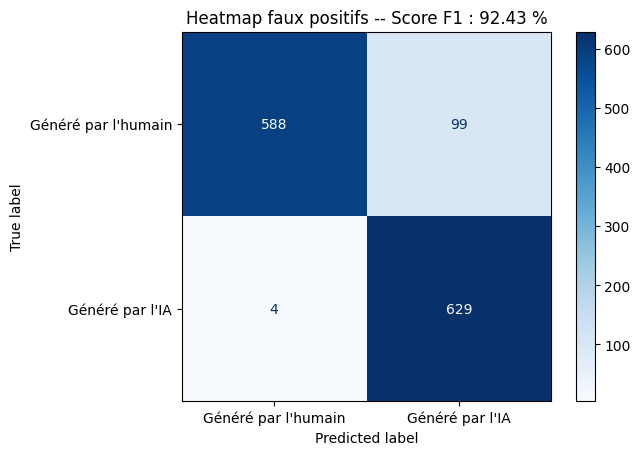

In [ ]:
createDataviz(y_test, prediction_results)

In [ ]:
# Essai avec la totalité des données (plus de 20000 données)
full_prediction_results = compiled_model.predict(data2.text)

# En fait non. Flemme d'attendre 13 heures.

   1/1244 ━━━━━━━━━━━━━━━━━━━━ 13:09:58 38s/step

KeyboardInterrupt: 

# 6. Conclusions

On constate ainsi que notre modèle a obtenu un score F1 de 92.43% d'accuarcy. C'est un plutôt beau résultat. Prenons maintenant du recul :  

- Le modèle est entrainé uniquement sur une liste d'essays. Si on essaie de sortir de ce scope, et lui faire passer en entrée du texte français ou dans un format différent (dialogue, texte très court...), les résultats sont de bien moindre qualité.
- Dans notre confusion matrix, sur 687 essays générés par humains, 99 ont été détectés en faux positifs ! Le modèle n'est pas la vérité absolue, difficile de faire un conseil de discipline pour une centaine de personnes alors qu'il n'y a pas eu de triche.

Pour récapituler note méthodo :

![recap](https://github.com/LoganTann/S7-PJ-Scala/assets/28659185/4d68e462-3ad8-4809-9ed5-7dc908dd83c8)


## Sources

Nous nous sommes fortement inspirés de ces ressources :  
- https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-llm-detect-ai-generate/notebook  
  Usage de distilbert, très facile à finetuner avec des résultats très bons.
- https://medium.com/@odil.tokhirov/trying-to-solve-a-kaggle-competition-llm-detect-ai-generated-text-part-2-d9cc360d81ab  
  Importance de la bonne distribution des données.